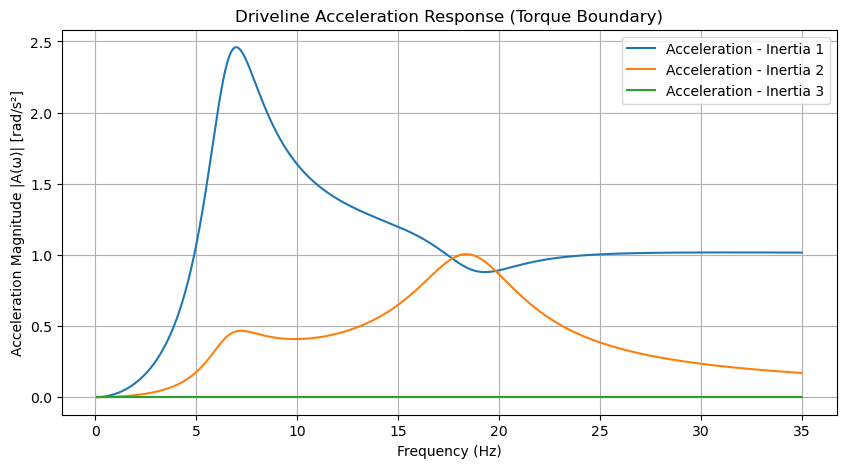

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, solve

###############################################################################
# USER INPUT: N-DOF Driveline System (Torque Boundary Condition)
###############################################################################
m = np.array([1.0, 1.0, 2.0])      # Inertia values [kg·m²]
c = np.array([25.0, 2.0, 3.0])     # Damping coefficients [N·m·s/rad]
k = np.array([2000.0, 12000.0, 6000.0])  # Stiffness values [N·m/rad]

f_min = 0.1    # Hz
f_max = 35.0   # Hz
num_points = 1000

###############################################################################
# SYSTEM ASSEMBLY FUNCTIONS
###############################################################################
def build_chain_matrices(m, c, k):
    """
    Builds the mass, damping, and stiffness matrices for an N-DOF system
    where inertias are connected by torsional springs and dampers.
    """
    N = len(m)
    M = np.diag(m)
    C = np.zeros((N, N))
    K = np.zeros((N, N))
    
    for i in range(N - 1):
        C[i, i] += c[i]
        C[i, i+1] -= c[i]
        C[i+1, i] -= c[i]
        C[i+1, i+1] += c[i]
        
        K[i, i] += k[i]
        K[i, i+1] -= k[i]
        K[i+1, i] -= k[i]
        K[i+1, i+1] += k[i]
    
    return M, C, K

###############################################################################
# TORQUE BOUNDARY IMPLEMENTATION
###############################################################################
def compute_NDOF_response_torque_boundary(m, c, k, w):
    """Solves the frequency-domain response of an N-DOF driveline system 
    using a torque input at one inertia and a zero displacement reference at another inertia."""
    N = len(m)
    M, C, K = build_chain_matrices(m, c, k)
    
    # Dynamic Stiffness Matrix: Z(w) = K - w^2 M + j w C
    Z = K - w**2 * M + 1j * w * C
    
    # Apply Torque at the first inertia, Reference Displacement at last inertia
    F = np.zeros(N, dtype=complex)
    F[0] = 1.0  # Apply unit torque at the first inertia
    
    # Set the last inertia as the zero-displacement reference
    Z_reduced = Z[:-1, :-1]
    F_reduced = F[:-1]
    
    # Solve for the reduced system
    X_reduced = solve(Z_reduced, F_reduced)
    X = np.append(X_reduced, 0)  # Append zero displacement for reference inertia
    
    return X

###############################################################################
# FREQUENCY RESPONSE COMPUTATION
###############################################################################
f_vals = np.linspace(f_min, f_max, num_points)
w_vals = 2 * np.pi * f_vals

X_vals = np.zeros((len(m), num_points), dtype=complex)
A_vals = np.zeros((len(m), num_points), dtype=complex)

for i, w in enumerate(w_vals):
    X_vals[:, i] = compute_NDOF_response_torque_boundary(m, c, k, w)
    A_vals[:, i] = -w**2 * X_vals[:, i]

###############################################################################
# PLOTTING RESULTS
###############################################################################
plt.figure(figsize=(10, 5))
for i in range(len(m)):
    plt.plot(f_vals, np.abs(A_vals[i, :]), label=f'Acceleration - Inertia {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Acceleration Magnitude |A(ω)| [rad/s²]')
plt.title('Driveline Acceleration Response (Torque Boundary)')
plt.legend()
plt.grid()
plt.show()
